In [1]:
import json
import os
import argparse

import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from torch.utils.data import DataLoader, Subset
import sys
sys.path.append('../../lib/exlib/src')
# from exlib.modules.sop import SOPImageCls, SOPConfig, get_chained_attr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)
    
# model paths
backbone_model_name = 'google/vit-base-patch16-224'
backbone_processor_name = 'google/vit-base-patch16-224'

# data paths
# TRAIN_DATA_DIR = '../data/imagenet_m/train'
# VAL_DATA_DIR = '../data/imagenet_m/val'
TRAIN_DATA_DIR = '/scratch/datasets/imagenet/train'
VAL_DATA_DIR = '/scratch/datasets/imagenet/val'


# training args
batch_size = 16
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

from exlib.modules.sop import get_chained_attr

backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
processor = AutoImageProcessor.from_pretrained(backbone_processor_name)
backbone_config = AutoConfig.from_pretrained(backbone_model_name)

from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

def resize_binary_image(image, size, mode='bilinear'):
    # Resize the image
    resized_image = F.interpolate(image, size=size, mode=mode, align_corners=False)

    # Threshold the image to convert values back to binary (0 or 1)
    thresholded_image = (resized_image > 0.5).float()

    return thresholded_image

from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os


class ImageFolderSubDataset(Dataset):
    def __init__(self, data_dir, attr_dir, transform=None, num_data=-1, start_data=0):
        self.data_dir = data_dir
        self.attr_dir = attr_dir
        self.transform = transform
        self.image_paths = []
        self.attr_paths = []
        self.labels = []
        
        for label in sorted(os.listdir(data_dir)):
            dirname = os.path.join(data_dir, label)
            if not os.path.isdir(dirname):
                continue
            for i, image_path in enumerate(sorted(os.listdir(dirname))):
                if i < start_data:
                    continue
                if num_data != -1 and i >= num_data:
                    break
                attr_path = os.path.join(self.attr_dir, label, os.path.basename(image_path) + '.pt')
                if not os.path.exists(attr_path):
                    print('failed' + attr_path)
                    continue
                self.image_paths.append(os.path.join(data_dir, label, image_path))
                self.attr_paths.append(attr_path)
                self.labels.append(label)
        self.all_labels = sorted(list(set(self.labels)))
        
        print('Loaded {} images and {} classes'.format(len(self.image_paths), len(self.all_labels)))

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        attr_path = self.attr_paths[idx]
        label = self.all_labels.index(self.labels[idx])
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
            
        attr = torch.load(attr_path)
        return image, label, attr
    
import math
import matplotlib.pyplot as plt

def show_masked_img(img, mask, ax):
    ax.imshow(img.permute(1,2,0).cpu().numpy())
    ax.imshow(mask.cpu().numpy(), cmap='hot', alpha=0.5)
    ax.contour(mask.cpu().numpy(), 2, colors='black', linestyles='dashed')
    ax.contourf(mask.cpu().numpy(), 2, hatches=['//', None, None],
                cmap='gray', extend='neither', linestyles='-', alpha=0.01)
    ax.axis('off')
    
def show_masks(img, masks, titles=None, cols=5, imgsize=3):
    n_masks = len(masks)
    rows = math.ceil(n_masks / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * imgsize, rows * imgsize))
    axes = axes.ravel()
    for m_i in range(len(masks)):
        mask = masks[m_i]
        show_masked_img(img, mask, axes[m_i])
        if titles is not None:
            axes[m_i].set_title(titles[m_i])
    for m_i in range(len(masks), len(axes)):
        axes[m_i].axis('off')
    plt.show()
    
def get_mask_weights_titles(mask_weights):
    titles = [f'{mask_weight.item():.10f}' for mask_weight in mask_weights]
    return titles

from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return WrappedBackboneOutput(outputs.logits, outputs.hidden_states[-1][:,0])
    
class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits
    
import copy
# only finetune last layer
backbone_model_type = 'vit'
if backbone_model_type == 'resnet':
    original_model = copy.deepcopy(backbone_model).to(device)
else:
    original_model = WrappedModel(copy.deepcopy(backbone_model)).to(device)
original_model.eval();

model = copy.deepcopy(backbone_model).to(device)
    
for name, param in model.named_parameters():
    param.requires_grad = False
    
for name, param in get_chained_attr(model, 'classifier').named_parameters():
    param.requires_grad = True

mfaba
Loaded 1000 images and 1000 classes
mfaba


0it [00:00, ?it/s]

Angora


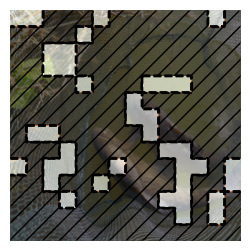

dalmatian


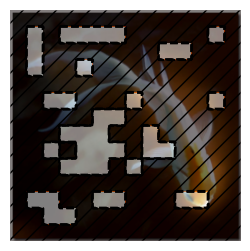

great white shark


KeyboardInterrupt: 

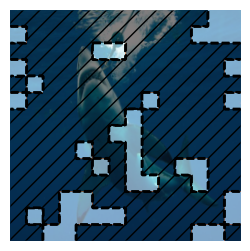

In [3]:
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm
from exlib.evaluators.common import convert_idx_masks_to_bool

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def transform(image):
    # Preprocess the image using the ViTImageProcessor
    image = image.convert("RGB")
    inputs = processor(image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)


methods = [
    # 'archipelago',
    # 'attn',
    # 'fullgrad',
    # 'gradcam',
    # 'intgrad',
    # 'lime',
    # 'lime_20',
    # 'rise',
    # 'rise_20',
    # 'shap',
    # 'shap_20'
    'mfaba',
    'agi',
    'ampe',
    'bcos',
    'xdnn',
    'bagnet'
]

results_all_als = defaultdict(list)



for method in methods:
    print(method)
    method_list = method.split('_')
    explainer_name = method_list[0]
    if len(method_list) == 2:
        suffix = '_' + method_list[1]
    else:
        suffix = ''
    # ATTR_VAL_DATA_DIR = f'../exps/imagenet_vit_1/attributions/{explainer_name}_5_pred{suffix}/val'
    # val_dataset = ImageFolderSubDataset(VAL_DATA_DIR, attr_dir=ATTR_VAL_DATA_DIR, transform=transform, 
    #                                     num_data=5, start_data=1)
    # val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # ATTR_VAL_DATA_DIR = f'../exps/imagenet_vit_1/attributions/{explainer_name}_5_pred{suffix}/val'
    
    ATTR_VAL_DATA_DIR = f'../../exps/imagenet_vit_1/attributions/vit_{explainer_name}_1_pred{suffix}/val'
    val_dataset = ImageFolderSubDataset(VAL_DATA_DIR, attr_dir=ATTR_VAL_DATA_DIR, transform=transform, 
                                        num_data=1, start_data=0)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # val_size = 1
    # for k in tqdm(np.linspace(0.1, 1, 10)):
    # # k = 0.2
    #     val_acc_k_results = get_acc(val_dataloader, k=k, eval_all=True)
    #     results_all_als[method].append(val_acc_k_results)
    # print(results_all_als[method][0]['acc'])
    model.eval();
    print(explainer_name)
    k = 0.2
    def show_masks_save(img, masks, titles=None, cols=5, imgsize=3, save_path=None):
        n_masks = len(masks)
        rows = math.ceil(n_masks / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * imgsize, rows * imgsize))
        try:
            axes = axes.ravel()
        except:
            axes = [axes]
        for m_i in range(len(masks)):
            mask = masks[m_i]
            show_masked_img(img, mask, axes[m_i])
            if titles is not None:
                axes[m_i].set_title(titles[m_i])
        for m_i in range(len(masks), len(axes)):
            axes[m_i].axis('off')
        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.show()

    for bi, batch in tqdm(enumerate(val_dataloader)):
        if bi in [0, 10, 20, 30]:
            # break

            inputs, labels, attrs = batch
            inputs, labels, attrs = inputs.to(device), labels.to(device), attrs.to(device)
            with torch.no_grad():
                original_outputs = original_model(inputs)
                original_logits = original_outputs
                original_preds = original_logits.argmax(-1)
                # Get explanation
                # expln = explainer(inputs, original_preds)

            # Get masks
            masks_all = []
            for idx in range(len(inputs)):
                # Create a mask of size (28, 28) with values from 1 to 28*28
                cell_size = 14
                image_size = 224
                mask = torch.arange(1, cell_size*cell_size + 1, dtype=torch.int).reshape(cell_size, cell_size)

                # Resize the mask to (224, 224) without using intermediate floating point numbers
                # This can be achieved by repeating each value in both dimensions to scale up the mask
                scale_factor = image_size // cell_size  # Calculate scale factor
                resized_mask = mask.repeat_interleave(scale_factor, dim=0).repeat_interleave(scale_factor, dim=1)

                masks = convert_idx_masks_to_bool(resized_mask[None]).to(device)
                mask_weights = (masks.to(device) * attrs[idx][0:1].to(device)).sum(-1).sum(-1).to(device)
                sort_idxs = torch.argsort(mask_weights).flip(-1)
                masks = masks[sort_idxs]
                mask_weights = mask_weights[sort_idxs]

                topk = int(masks.shape[0] * k)
                masks_use = masks[:topk]
                mask = masks_use.sum(0)

                masks_all.append(mask)
            masks_all = torch.stack(masks_all, dim=0)

            # Get masked output

            masked_inputs = masks_all[:,None] * inputs
            # plt.figure()
            # plt.imshow(masked_inputs[0].permute(1,2,0))
            with torch.no_grad():
                outputs = model(masked_inputs)
            logits = outputs.logits
            preds = logits.argmax(-1)
            preds = torch.argmax(outputs.logits, dim=-1)
            root_dir = '../neurips2024_user_study2'
            save_dir = f'{root_dir}/imgs'
            save_dir_label = f'{root_dir}/labels'
            os.makedirs(save_dir, exist_ok=True)
            os.makedirs(save_dir_label, exist_ok=True)
            for idx in range(4):
                print(backbone_config.id2label[preds[idx].item()].split(',')[0])
                # show_masks_pure(inputs, outputs, idx=idx, k=1)
                denormed_img = (inputs[idx:idx+1] + 1) / 2
                # print('original')
                # plt.figure()
                # plt.imshow(denormed_img[0].cpu().permute(1,2,0))
                # plt.axis('off')
                # plt.savefig(os.path.join(save_dir, f'{bi}_{idx}_original.png'), dpi=300, bbox_inches='tight', pad_inches=0)
                # plt.show()
                show_masks_save(denormed_img[0], masks_all[idx:idx+1], 
                                save_path=os.path.join(save_dir, f'{bi}_{idx}_{explainer_name}.png'), cols=1)
                # show_masks_weights_save(inputs, outputs, preds, idx=idx, save_path=os.path.join(save_dir, f'{bi}_{idx}_gradcam.png'))
                with open(os.path.join(save_dir_label, f'{bi}_{idx}_{explainer_name}.txt'), 'wt') as output_file:
                    output_file.write(backbone_config.id2label[preds[idx].item()].split(',')[0])